In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Generating data using different distribution

In [2]:
n_samples=1000
np.random.seed(5)
x1=np.random.weibull(2,n_samples)
x2=np.random.weibull(3,n_samples)*1.5
x3=np.random.normal(0,1,n_samples)
x4=np.random.beta(2,5,n_samples)
x5=np.random.exponential(0.5,n_samples)
coefficients=np.random.rand(5)
y = coefficients[0]*x1 + coefficients[1]*x2 + coefficients[2]*x3 + coefficients[3]*x4 + coefficients[4]*x5 + np.random.normal(2,0.5,n_samples)

In [3]:
data = {
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'x5': x5,
    'target': y
}
df=pd.DataFrame(data)

### Description of data

In [4]:
df.describe()

,x1,x2,x3,x4,x5,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.875305,1.375017,-0.039207,0.289021,0.481878,2.963499
std,0.450936,0.480109,0.997215,0.159157,0.476266,0.660323
min,0.019570,0.154486,-3.507475,0.008339,0.000255,1.191663
25%,0.538080,1.023893,-0.721560,0.167162,0.125976,2.511850
50%,0.829421,1.358117,-0.040458,0.269293,0.336819,2.952338
75%,1.173568,1.706695,0.617761,0.387356,0.664678,3.399084
max,2.552030,3.109389,2.853769,0.839504,2.820631,5.570302


### Correlation between covariates and response

<Axes: >

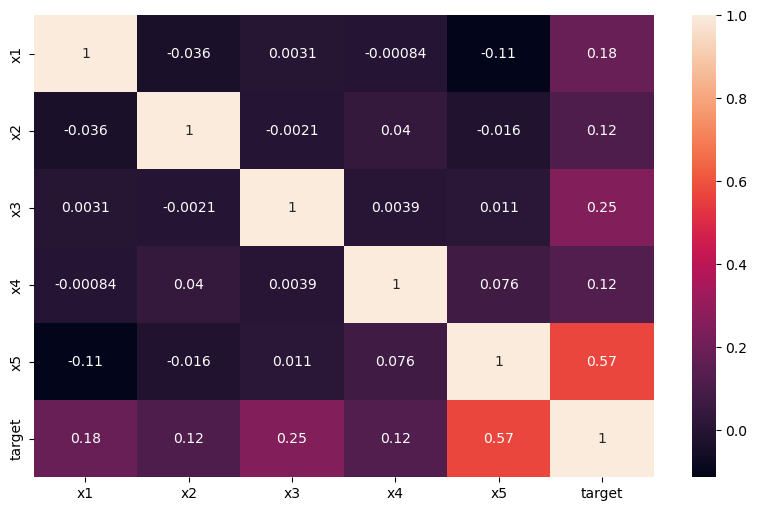

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)

### Insights
- X5 and target are highly correlated

### Box Plot of all variables

<Axes: >

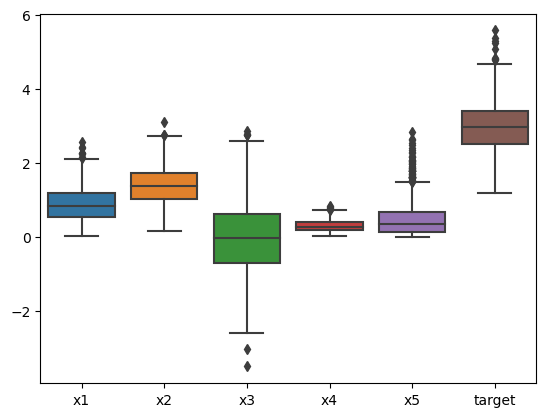

In [6]:
sns.boxplot(df)

## Insights
- Every variable has some outliers -X5,target,X1 has more outliers than others

## Handling outliers, we used technique of removing rows and replacing it by mean or median

In [7]:
minimum,Q1,Q2,Q3,maximum=np.quantile(df['x1'],[0,0.25,0.50,0.75,1.0])
IQR = Q3-Q1
lower_fence = Q1-1.5*(IQR)
higher_fence=Q3+1.5*(IQR)
replacement_value = 0.829421

# Iterate over the indices of the DataFrame
for i in df.index:
    value = df.at[i, 'x1']  # Get the value of 'x5' at index i
    if value < lower_fence or value > higher_fence:
        df.at[i, 'x1'] = replacement_value

In [8]:
##Finding Outliers
minimum,Q1,Q2,Q3,maximum=np.quantile(df['x2'],[0,0.25,0.50,0.75,1.0])
IQR = Q3-Q1
lower_fence = Q1-1.5*(IQR)
higher_fence=Q3+1.5*(IQR)
df = df[(df['x2'] >= lower_fence) & (df['x2'] <= higher_fence)]

In [9]:
minimum,Q1,Q2,Q3,maximum=np.quantile(df['x3'],[0,0.25,0.50,0.75,1.0])
IQR = Q3-Q1
lower_fence = Q1-1.5*(IQR)
higher_fence=Q3+1.5*(IQR)
replacement_value = -0.039207

# Iterate over the indices of the DataFrame
for i in df.index:
    value = df.at[i, 'x3']  # Get the value of 'x5' at index i
    if value < lower_fence or value > higher_fence:
        df.at[i, 'x3'] = replacement_value

In [10]:
minimum,Q1,Q2,Q3,maximum=np.quantile(df['x5'],[0,0.25,0.50,0.75,1.0])
IQR = Q3-Q1
lower_fence = Q1-1.5*(IQR)
higher_fence=Q3+1.5*(IQR)
replacement_value = 0.480819

# Iterate over the indices of the DataFrame
for i in df.index:
    value = df.at[i, 'x5']  # Get the value of 'x5' at index i
    if value < lower_fence or value > higher_fence:
        df.at[i, 'x5'] = replacement_value

In [11]:
minimum,Q1,Q2,Q3,maximum=np.quantile(df['target'],[0,0.25,0.50,0.75,1.0])
IQR = Q3-Q1
lower_fence = Q1-1.5*(IQR)
higher_fence=Q3+1.5*(IQR)
replacement_value = 2.961950

# Iterate over the indices of the DataFrame
for i in df.index:
    value = df.at[i, 'target']  # Get the value of 'x5' at index i
    if value < lower_fence or value > higher_fence:
        df.at[i, 'target'] = replacement_value

## Boxplot after removing outliers

<Axes: >

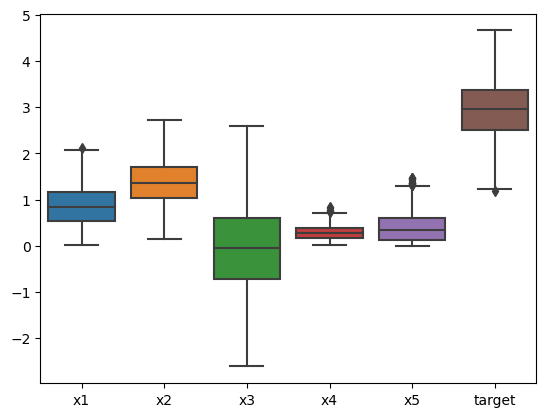

In [12]:
sns.boxplot(df)  

## Training data 
## Applying Random survival forest on training data and then predicting by test data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = df.drop(columns=['target'])
binary_numbers = np.random.randint(2, size=997)
y = pd.DataFrame(binary_numbers, columns=['cens'], index=X.index)
y = pd.concat([y, df['target']], axis=1)
event_indicator_train = np.array(y["cens"], dtype=bool)
time_of_event_train = np.array(y["target"], dtype=float)
y= np.array(list(zip(event_indicator_train, time_of_event_train)), dtype=[('event', bool), ('time', float)])

In [15]:
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2,random_state=1234)

In [16]:
from sksurv.ensemble import RandomSurvivalForest

In [17]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=20
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

### Calculating score

In [18]:
rsf.score(X_test, y_test)

0.682282098387426

# The score is 68.23%

In [21]:
X_test_sorted = X_test.sort_values(by=["x3", "x5"])
pd.Series(rsf.predict(X_test_sorted))

0      348.398251
1      352.756529
2      126.902714
3      305.675698
4      291.713590
          ...    
195    217.700268
196    305.737673
197     65.795359
198    203.899555
199     76.309319
Length: 200, dtype: float64